In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from typing import Callable, Tuple, Any
import numpy as np
from functools import partial
import pdb
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
import seaborn

2025-05-12 13:22:03.893620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747056123.918508     367 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747056123.925635     367 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!nvidia-smi

Mon May 12 13:22:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Load the MNIST dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_train, Y_train, X_test, Y_test = jnp.expand_dims(jnp.array(X_train/255), axis=-1), jnp.expand_dims(jnp.array(Y_train), axis=-1), jnp.expand_dims(jnp.array(X_test/255), axis=-1), jnp.expand_dims(jnp.array(Y_test), axis=-1)

In [4]:
X_train.shape, Y_train.shape

((60000, 28, 28, 1), (60000, 1))

In [5]:
(jnp.ones((4, 1, 3, 3, 128, 1)) @ jnp.ones((1, 16, 1, 1, 1, 8))).shape

(4, 16, 3, 3, 128, 8)

In [6]:
@jax.jit
def get_sample_and_label(idx, inputs, labels):
    return inputs[idx], labels[idx]

arr = jnp.array([32,67,432,2])
xb, yb = jax.vmap(get_sample_and_label, in_axes=(0,None,None))(arr, X_train, Y_train)
xb.shape, yb.shape

((4, 28, 28, 1), (4, 1))

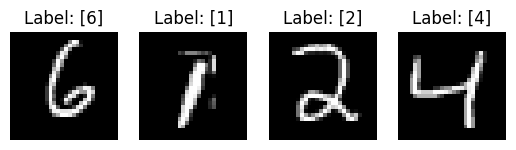

In [7]:
for i in range(4):
    # Save image
    img = Image.fromarray(np.asarray(xb[i][-1]))

    # Predict
    actual = yb[i]

    # Plot image
    plt.subplot(1, 4, i + 1)
    plt.imshow(xb[i], cmap='gray')
    plt.title(f"Label: {actual}")
    plt.axis('off')

In [8]:
class S6_Unet(nn.Module):
    embed_dim: int = 32
    n_latent_dim: int = 8

    @nn.compact
    def __call__(self, x, h=0):
        # x.shape = (Ba, n_filters, seq_size, hidden_dim)
        _, h, w, hidden_dim = x.shape
        Ba = x.shape[0]
        # A = -1* self.param('A', nn.initializers.ones, (1,  self.n_latent_dim, self.embed_dim , self.embed_dim))
        B = self.param('B', nn.initializers.ones, (1, self.n_latent_dim, 1, 1, 1, self.embed_dim))
        C = self.param('C', jax.random.normal, (1,  h, w, self.embed_dim, 1))
        D = self.param('D', nn.initializers.ones, (1, self.n_latent_dim, 1, 1, 1, self.embed_dim))
        S = -0.5* self.param('S', nn.initializers.ones, (1, self.n_latent_dim, 1, 1, 1, self.embed_dim))
        # h = h*jnp.ones((Ba,  self.n_latent_dim, hidden_dim, self.embed_dim))
        return self.ssm(x, B, C, D, S)
        
    def ssm(self, x, B, C, D, S):
        def compute_delta(x, B):
            # State update: (B, n, 3, 3, D, H) <- (B, 1, 3, 3, D, H) @ (1, n, 1, H, H)
            # state_contribution = nn.RMSNorm()(state@A)
            # Input contribution: (B, n, 3, 3, D, H) <- (B, 1, 3, 3, D, 1) @ (1, n, 1, 1, 1, H)
            input_contribution = x@B
            # print("state_contribution + input_contribution: ", state_contribution.sum(), input_contribution.sum())
            return input_contribution

#         for k in range(x.shape[-1]):
#             # Compute ∆, the state update candidates
# #             pdb.set_trace()
#             # print("k: ", k)
        delta = compute_delta(jnp.expand_dims(x, axis=(1,5)), B)
        #h: (B, 3, 3, D, H) <- (B, n, 3, 3, D, H)*((B, 1, 3, 3, D, 1) @ (1, n, 1, 1, 1, H))
        h = delta*(jnp.expand_dims(x, axis=(1,5))@S)
            # print("h sum:", h.min(), h.max(), jnp.sum(h))
        # pdb.set_trace()
        #y: (B, N, D, 1) <- (B, N, D, H) @ (1, N, H, 1) + (B, 1, D, 1)*(1, N, D, 1)
        # y = h @ C + jnp.expand_dims(x[:,-1,:], axis=(1,3))*D
        #h: (B, n, 3, 3, D, 1) <- (B, n, 3, 3, D, H) @ (1, n, 3, 3, H, 1) + (B, 1, 3, 3, D, 1) @ (1, n, 1, 1, 1, H)
        h = h @ C + jnp.expand_dims(x, axis=(1,5))@D
        return jnp.einsum('bnhwd1->bhwd', h)

In [9]:
class VisionEncoder(nn.Module):
    patch_size: int = 2
    hidden_dim: int = 64

    @nn.compact
    def __call__(self, x):
        # Assuming input shape: (batch, height, width, channels)
        # Patch embedding

########################################################################################################################################

        for i in range(3):
            x = nn.Conv(
                features=self.hidden_dim*(2**i),
                kernel_size=(self.patch_size, self.patch_size),
                strides=(1, 1)
                )(x)

            x = nn.max_pool(x, window_shape=(self.patch_size, self.patch_size), strides=(self.patch_size, self.patch_size))

        # print("After conv", x.shape)
        # x = x.reshape(x.shape[0], -1, x.shape[-1])
        # print("After reshape",x.shape)
        h = S6_Unet()(jax.nn.silu(nn.RMSNorm()(x)))
        # print("After S6", h.shape)
        
        return nn.Dense(10)(h.reshape(h.shape[0], 1, -1)), h
########################################################################################################################################



########################################################################################################################################
        # x = jax.nn.silu(nn.Conv(features=64, kernel_size=(self.patch_size, self.patch_size))(x))
        # print("After first conv: ", x.shape)
        # x = nn.max_pool(x, window_shape=(2, 2), strides=(self.patch_size, self.patch_size))
        # print("After first max pool: ", x.shape)
        # x = jax.nn.silu(nn.Conv(features=128, kernel_size=(self.patch_size, self.patch_size))(x))
        # print("After 2nd conv: ", x.shape)
        # x = nn.max_pool(x, window_shape=(2, 2), strides=(self.patch_size, self.patch_size))
        # print("After 2nd max pool: ", x.shape)
        # x = jax.nn.silu(nn.Conv(features=256, kernel_size=(self.patch_size, self.patch_size))(x))
        # print("After 3rd conv: ", x.shape)
        # x = x.reshape(x.shape[0], -1)  # flatten
        # print("After flatten: ", x.shape)
        # x = jax.nn.silu(nn.Dense(256)(x))
########################################################################################################################################

########################################################################################################################################
        # # Flatten patches
        # x =x.reshape(x.shape[0], -1, x.shape[-1])

        # # Transformer blocks
        # for _ in range(6):  # 6 layers
        #     x = nn.MultiHeadDotProductAttention(
        #         num_heads=8,
        #         qkv_features=self.hidden_dim
        #     )(x)
        #     x = nn.LayerNorm()(x)

        # # Projection to embedding dimension
        # x = jax.nn.silu(nn.Dense(self.embed_dim)(jax.nn.silu(x.mean(axis=1))))
########################################################################################################################################

        # x = nn.Dense(10)(x)
        # return jnp.expand_dims(x, axis=1)

model = VisionEncoder()
params = model.init(jax.random.PRNGKey(451),jnp.ones((1,28,28,1)))
n_params = sum(p.size for p in jax.tree_util.tree_leaves(params))
print(f"Total number of parameters: {n_params:_}")


Total number of parameters: 188_906


In [10]:
finl, hdn = model.apply(params,jnp.ones((1,28,28,1)))
print(finl.shape, hdn.shape)

(1, 1, 10) (1, 3, 3, 256)


In [11]:
# opt = optax.sgd(learning_rate, momentum)
opt = optax.adamw(learning_rate=0.001)


opt_state = opt.init(params)

In [12]:
(256*3*3)/(27**2)

3.1604938271604937

In [13]:
def loss_fun(params, x, y):
    logits, _ = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

@jax.jit
def eval_step(params, x, y):
    logits, _ = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

In [14]:
%%time
key = jax.random.PRNGKey(42)  # Replace 42 with any random seed
BATCH_SIZE = 64
# learning_rate = 0.1
momentum = 0.9
train_length = len(X_train)//BATCH_SIZE
kernel_s = 2

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

eval_iters = 10000

@jax.jit
def step(idx, params, opt_state):
    xb, yb = jax.vmap(get_sample_and_label, in_axes=(0,None,None))(idx, X_train, Y_train)
    (loss, train_accuracy), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, train_accuracy

for i in range(eval_iters):
    key, subkey = jax.random.split(key)
    iix = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_train))
    params, opt_state, loss, train_accuracy = step(iix, params, opt_state)

    # once every N_FREQ_EVAL we compute loss on the validation set
    if i%100 == 0:
        key, subkey = jax.random.split(key)
        indxs = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_test))
        xt, yt = jax.vmap(get_sample_and_label, in_axes=(0,None,None))(indxs, X_test, Y_test)
        eval_loss, eval_accuracy = eval_step(params, xt, yt)
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print('####################################################################################################')
        print("Step: ", i,"\t\t Train Loss: ", format(loss, ".6f"),"\t\t Train Accuracy: ", format(train_accuracy, ".2%"))
        print("Step: ", i,"\t\t Eval Loss: ", format(eval_loss, ".6f"),"\t\t Eval Accuracy: ", format(eval_accuracy, ".2%"))

####################################################################################################
Step:  0 		 Train Loss:  1348.652954 		 Train Accuracy:  14.06%
Step:  0 		 Eval Loss:  797.277893 		 Eval Accuracy:  9.38%
####################################################################################################
Step:  100 		 Train Loss:  14.545086 		 Train Accuracy:  89.06%
Step:  100 		 Eval Loss:  7.656524 		 Eval Accuracy:  95.31%
####################################################################################################
Step:  200 		 Train Loss:  7.289197 		 Train Accuracy:  92.19%
Step:  200 		 Eval Loss:  13.089502 		 Eval Accuracy:  90.62%
####################################################################################################
Step:  300 		 Train Loss:  9.707142 		 Train Accuracy:  89.06%
Step:  300 		 Eval Loss:  0.000008 		 Eval Accuracy:  100.00%
#################################################################################################

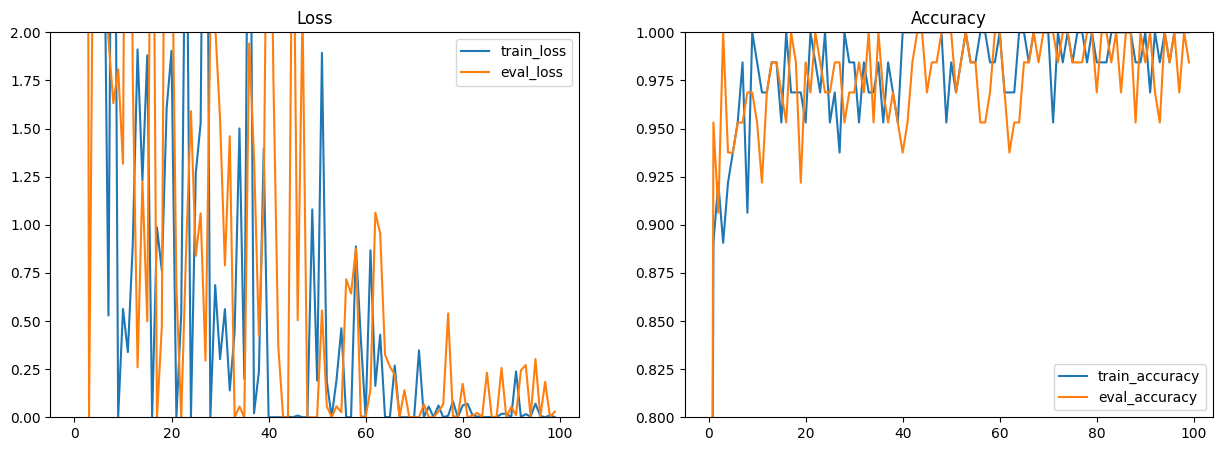

<Figure size 640x480 with 0 Axes>

In [15]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')
ax1.set_ylim(0, 2)

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')
ax2.set_ylim(0.8, 1)

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [16]:
X_train[1].shape

(28, 28, 1)

In [17]:
text_counter = np.zeros(10)

text_encoder = np.zeros((10, hdn.shape[1], hdn.shape[2], hdn.shape[-1]))

for ii in range(len(Y_test)):
    print("Counter: ",ii) if ii%100==0 else None
    text_counter[Y_test[ii][0]] += 1
    _, h = model.apply(params, jnp.expand_dims(X_test[ii], axis=0))
    text_encoder[Y_test[ii][0]] += h

for jj in range(10):
    text_encoder[jj] = text_encoder[jj]/text_counter[jj]

Counter:  0
Counter:  100
Counter:  200
Counter:  300
Counter:  400
Counter:  500
Counter:  600
Counter:  700
Counter:  800
Counter:  900
Counter:  1000
Counter:  1100
Counter:  1200
Counter:  1300
Counter:  1400
Counter:  1500
Counter:  1600
Counter:  1700
Counter:  1800
Counter:  1900
Counter:  2000
Counter:  2100
Counter:  2200
Counter:  2300
Counter:  2400
Counter:  2500
Counter:  2600
Counter:  2700
Counter:  2800
Counter:  2900
Counter:  3000
Counter:  3100
Counter:  3200
Counter:  3300
Counter:  3400
Counter:  3500
Counter:  3600
Counter:  3700
Counter:  3800
Counter:  3900
Counter:  4000
Counter:  4100
Counter:  4200
Counter:  4300
Counter:  4400
Counter:  4500
Counter:  4600
Counter:  4700
Counter:  4800
Counter:  4900
Counter:  5000
Counter:  5100
Counter:  5200
Counter:  5300
Counter:  5400
Counter:  5500
Counter:  5600
Counter:  5700
Counter:  5800
Counter:  5900
Counter:  6000
Counter:  6100
Counter:  6200
Counter:  6300
Counter:  6400
Counter:  6500
Counter:  6600
Counter

In [18]:
text_encoder.shape

(10, 3, 3, 256)

In [19]:
@jax.jit
def get_masked_images(idx, size, inputs, labels, text_encoder):
    print(idx, type(idx))
    rows_mask = jnp.ones(shape=(28,28))*jnp.arange(0,28)
    cols_mask = jnp.transpose(rows_mask)

    rows_mask = jnp.where((rows_mask>=size)&(rows_mask<size+size), 1, 0)
    cols_mask = jnp.where((cols_mask>=size)&(cols_mask<size+size), 1, 0)

    mask = jnp.reshape(-1*((rows_mask*cols_mask)-1), (28,28,1))
    return inputs[idx], labels[idx], inputs[idx]*mask, text_encoder[labels[idx][0].astype(int)]

Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=2/0)> <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
(8, 28, 28, 1)


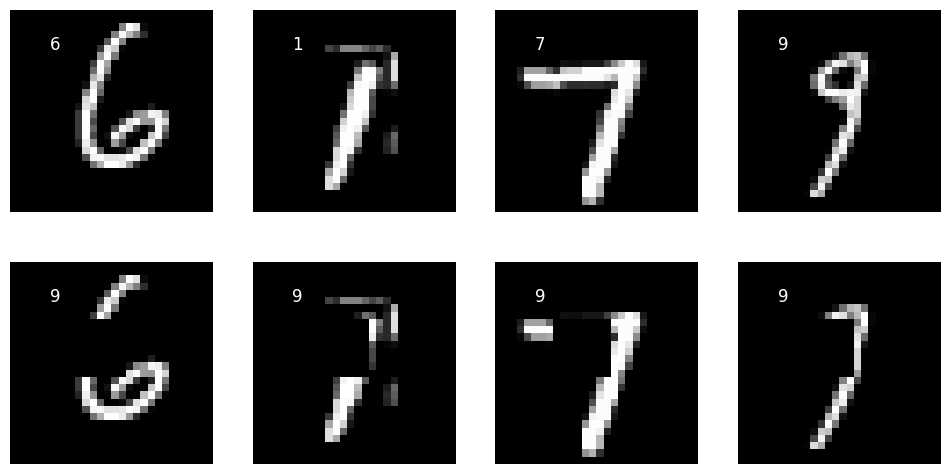

In [20]:
sample = 765
key = jax.random.PRNGKey(421)  # Replace 42 with any random seed
subkey_a, subkey_b = jax.random.split(key)
# ixx = jax.random.randint(subkey_a, shape=(1,), minval=0, maxval=23)
no_mask_img, ylabels, masked_img, y_latents = jax.vmap(get_masked_images, in_axes=(0, None, None,None, None))(jnp.array([32,67, 654, 864]), 8, X_train, Y_train, text_encoder)

# fig = plt.figure
# plt.imshow(masked_img, cmap='gray')
# plt.title('Label: {}'.format(Y_test[sample]))
# plt.show()

imggs = jnp.vstack([no_mask_img, masked_img])
print(imggs.shape)
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(imggs[i, ..., 0]*255, cmap='gray')
    ax.text(5, 5, ylabels[i][0], color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
    ax.axis('off')

In [21]:
y_latents.shape

(4, 3, 3, 256)

In [45]:
class ImageDecoder(nn.Module):

    @nn.compact
    def __call__(self, x, h=0):

        latents_dim = x.shape[-1]
        upscale1 = self.param('upscale1', nn.initializers.ones, (1, 28, hdn.shape[1], 28))
        upscale2 = self.param('upscale2', nn.initializers.ones, (1, 28, hdn.shape[1], 1))

        x = nn.Conv(features=latents_dim//2, kernel_size=(2, 2), padding='SAME')(x)
        x = nn.Conv(features=latents_dim//4, kernel_size=(2, 2), padding='SAME')(x)
        x = nn.Conv(features=28, kernel_size=(2, 2), padding='SAME')(x)

        x = jnp.transpose(x,(0, 3, 1, 2))

        x = x@upscale1

        x = jnp.transpose(x,(0, 1, 3, 2))

        x = x@upscale2

        return jax.nn.sigmoid(x)
        

In [46]:
dec_model = ImageDecoder()
dec_params = dec_model.init(jax.random.PRNGKey(451),jnp.ones((1,hdn.shape[1],hdn.shape[2],hdn.shape[-1]*2)))
n_params = sum(p.size for p in jax.tree_util.tree_leaves(dec_params))
print(f"Total number of parameters: {n_params:_}")

Total number of parameters: 672_544


In [47]:
sample_img = dec_model.apply(dec_params, jnp.ones((1,hdn.shape[1],hdn.shape[2],hdn.shape[-1]*2)))
sample_img.shape

(1, 28, 28, 1)

In [48]:
htr = jax.random.normal(subkey, ((4, 3, 3, 128)))
htrr = jax.random.normal(key, ((4, 3, 3, 128)))
batch_size = htr.shape[0]
htr = htr.reshape((batch_size,-1))
htrr = htrr.reshape((batch_size,-1))
print(htr.shape)
logits = jnp.matmul(htr, htr.T)
print(logits)
labels = jnp.eye(batch_size, dtype=jnp.float32)

# Sigmoid cross-entropy loss
pos_loss = -jnp.log(jax.nn.sigmoid(logits)) * labels
neg_loss = -jnp.log(1.0000001 - jax.nn.sigmoid(logits)) * (1 - labels)

jnp.mean(pos_loss + neg_loss)

(4, 1152)
[[ 1.1338551e+03  2.7529007e+01 -1.4670261e+01 -8.6089110e-01]
 [ 2.7529007e+01  1.1041116e+03 -4.7170761e+01  1.3519264e+01]
 [-1.4670261e+01 -4.7170761e+01  1.1452513e+03 -2.0122528e-03]
 [-8.6089110e-01  1.3519264e+01 -2.0122528e-03  1.1157852e+03]]


Array(3.8055775, dtype=float32)

In [49]:
1 - jax.nn.sigmoid(logits)

Array([[0.0000000e+00, 0.0000000e+00, 9.9999958e-01, 7.0284677e-01],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.3113022e-06],
       [9.9999958e-01, 1.0000000e+00, 0.0000000e+00, 5.0050306e-01],
       [7.0284677e-01, 1.3113022e-06, 5.0050306e-01, 0.0000000e+00]],      dtype=float32)

In [50]:
# opt = optax.sgd(learning_rate, momentum)
opt1 = optax.adamw(learning_rate=0.001)


opt_state1 = opt1.init(dec_params)

In [51]:
def sig_loss_fn(dec_params, img, label, mask_img, y_lat):
    _, mask_lat = model.apply(params, mask_img)
    dec_input = jnp.concatenate([mask_lat, y_lat], axis=-1)
    dec_img = dec_model.apply(dec_params, dec_input)
    preds, _ = model.apply(params,dec_img)
    # _, img_lat = model.apply(params, img)

    batch_size = img.shape[0]

    dec_img_lat = dec_img.reshape((batch_size,-1))
    img_lat = img.reshape((batch_size,-1))
    # print(dec_img_lat.shape)
    # print(img_lat.shape)
    dec_img_lat = dec_img_lat / jnp.linalg.norm(dec_img_lat, axis=-1, keepdims=True)
    img_lat = img_lat / jnp.linalg.norm(img_lat, axis=-1, keepdims=True)

    logits = jnp.matmul(dec_img_lat, img_lat.T)
    
    labels = jnp.eye(batch_size, dtype=jnp.float32)
    
    # Sigmoid cross-entropy loss
    pos_loss = -jnp.log(jax.nn.sigmoid(logits)) * labels
    neg_loss = -jnp.log(1 - jax.nn.sigmoid(logits)) * (1 - labels)

    accuracy = jnp.mean(jnp.argmax(preds, axis=-1) == label)
    return jnp.mean(pos_loss + neg_loss), accuracy

In [52]:
@jax.jit
def sig_eval_step(dec_params, img, label, mask_img, y_lat):
    _, mask_lat = model.apply(params, mask_img)
    dec_input = jnp.concatenate([mask_lat, y_lat], axis=-1)
    dec_img = dec_model.apply(dec_params, dec_input)
    preds, _ = model.apply(params,dec_img)
    # _, img_lat = model.apply(params, img)

    batch_size = img.shape[0]

    dec_img_lat = dec_img.reshape((batch_size,-1))
    img_lat = img.reshape((batch_size,-1))
    # print(dec_img_lat.shape)
    # print(img_lat.shape)
    dec_img_lat = dec_img_lat / jnp.linalg.norm(dec_img_lat, axis=-1, keepdims=True)
    img_lat = img_lat / jnp.linalg.norm(img_lat, axis=-1, keepdims=True)

    logits = jnp.matmul(dec_img_lat, img_lat.T)
    
    labels = jnp.eye(batch_size, dtype=jnp.float32)
    
    # Sigmoid cross-entropy loss
    pos_loss = -jnp.log(jax.nn.sigmoid(logits)) * labels
    neg_loss = -jnp.log(1 - jax.nn.sigmoid(logits)) * (1 - labels)

    accuracy = jnp.mean(jnp.argmax(preds, axis=-1) == label)
    return jnp.mean(pos_loss + neg_loss), accuracy

In [53]:
# def sig_loss_fn(dec_params, img, label, mask_img, y_lat):
#     _, mask_lat = model.apply(params, mask_img)
#     dec_input = jnp.concatenate([mask_lat, y_lat], axis=-1)
#     dec_img = dec_model.apply(dec_params, dec_input)
#     logits, dec_img_lat = model.apply(params,dec_img)
#     accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == label)
#     return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=label).mean(), accuracy

# @jax.jit
# def sig_eval_step(dec_params, img, label, mask_img, y_lat):
#     _, mask_lat = model.apply(params, mask_img)
#     dec_input = jnp.concatenate([mask_lat, y_lat], axis=-1)
#     dec_img = dec_model.apply(dec_params, dec_input)
#     logits, dec_img_lat = model.apply(params,dec_img)
#     accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == label)
#     return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=label).mean(), accuracy

In [54]:
%%time
key = jax.random.PRNGKey(428)  # Replace 42 with any random seed
BATCH_SIZE = 64
# learning_rate = 0.1
momentum = 0.9
train_length = len(X_train)//BATCH_SIZE

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

eval_iters = 10000

@jax.jit
def step(idx, dec_params, opt_state1):
    xb, yb, mb, y_latents = jax.vmap(get_masked_images, in_axes=(0, None, None, None, None))(idx, 8, X_train, Y_train, text_encoder)
    (loss, train_accuracy), grad = jax.value_and_grad(sig_loss_fn, has_aux=True)(dec_params, xb, yb, mb, y_latents)
    updates, opt_state1 = opt1.update(grad, opt_state1, dec_params)
    dec_params = optax.apply_updates(dec_params, updates)
    return dec_params, opt_state1, loss, train_accuracy

for i in range(eval_iters):
    key, subkey = jax.random.split(key)
    iix = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_train))
    dec_params, opt_state1, loss, train_accuracy = step(iix, dec_params, opt_state1)

    # once every N_FREQ_EVAL we compute loss on the validation set
    if i%100 == 0:
        key, subkey = jax.random.split(key)
        indxs = jax.random.randint(subkey, shape=(BATCH_SIZE,), minval=0, maxval=len(X_test))
        xt, yt, mt, y_lat = jax.vmap(get_masked_images, in_axes=(0, None, None, None, None))(indxs, 8, X_test, Y_test, text_encoder)
        eval_loss, eval_accuracy = sig_eval_step(dec_params, xt, yt, mt, y_lat)
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print('####################################################################################################')
        print("Step: ", i,"\t\t Train Loss: ", format(loss, ".6f"),"\t\t Train Accuracy: ", format(train_accuracy, ".2%"))
        print("Step: ", i,"\t\t Eval Loss: ", format(eval_loss, ".6f"),"\t\t Eval Accuracy: ", format(eval_accuracy, ".2%"))

####################################################################################################
Step:  0 		 Train Loss:  0.868298 		 Train Accuracy:  10.94%
Step:  0 		 Eval Loss:  0.744185 		 Eval Accuracy:  12.50%
####################################################################################################
Step:  100 		 Train Loss:  0.694825 		 Train Accuracy:  6.25%
Step:  100 		 Eval Loss:  0.695641 		 Eval Accuracy:  6.25%
####################################################################################################
Step:  200 		 Train Loss:  0.695567 		 Train Accuracy:  3.12%
Step:  200 		 Eval Loss:  0.695953 		 Eval Accuracy:  10.94%
####################################################################################################
Step:  300 		 Train Loss:  0.694197 		 Train Accuracy:  15.62%
Step:  300 		 Eval Loss:  0.696236 		 Eval Accuracy:  6.25%
####################################################################################################
Step:  

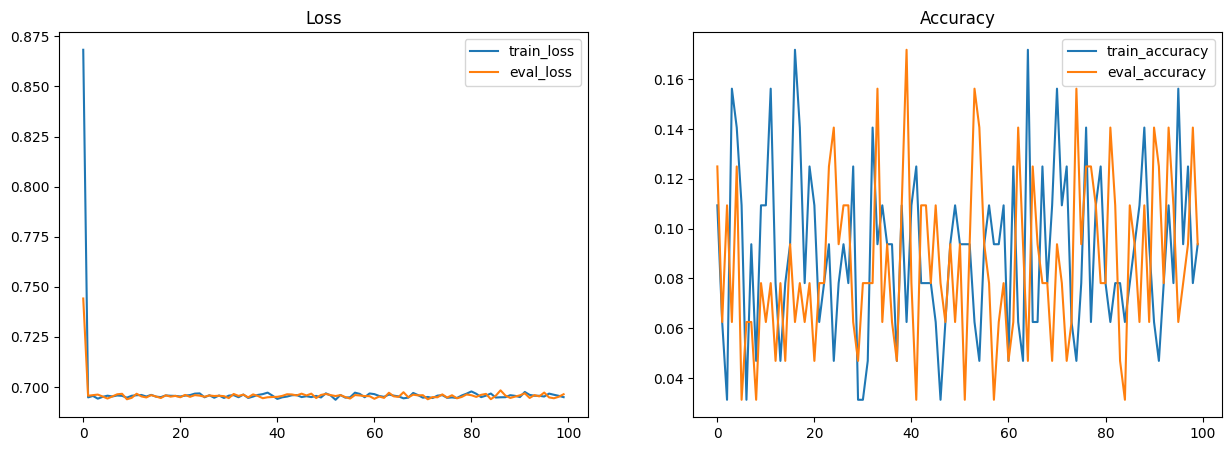

<Figure size 640x480 with 0 Axes>

In [55]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')
# ax1.set_ylim(0.6, 0.7)

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')
# ax2.set_ylim(0.0, 1)

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [56]:
masked_img.shape

(4, 28, 28, 1)

(12, 28, 28, 1)


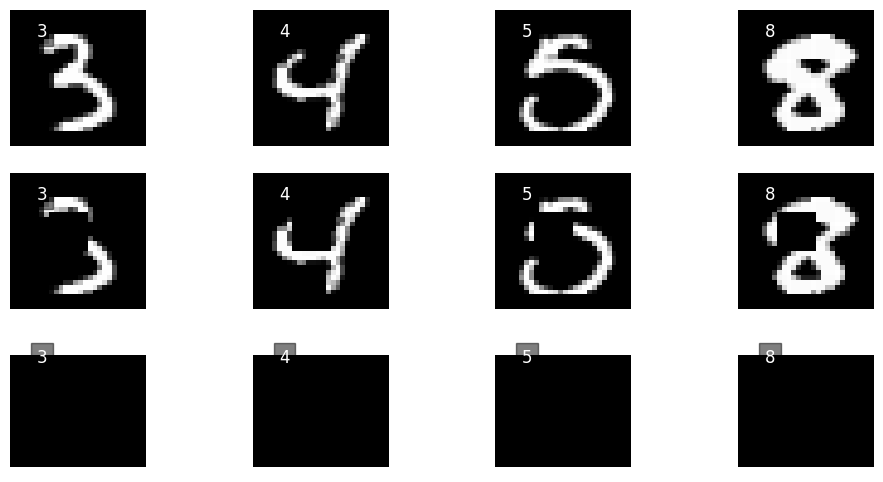

In [57]:
sample = 765
key = jax.random.PRNGKey(421)  # Replace 42 with any random seed
subkey_a, subkey_b = jax.random.split(key)
# ixx = jax.random.randint(subkey_a, shape=(1,), minval=0, maxval=23)
no_mask_img, ylabels, masked_img, y_latents = jax.vmap(get_masked_images, in_axes=(0, None, None,None, None))(jnp.array([32,67, 654, 864]), 8, X_test, Y_test, text_encoder)

# fig = plt.figure
# plt.imshow(masked_img, cmap='gray')
# plt.title('Label: {}'.format(Y_test[sample]))
# plt.show()
_, mask_lat = model.apply(params, masked_img)
dec_input = jnp.concatenate([mask_lat, y_latents], axis=-1)
recon_imgs = dec_model.apply(dec_params, dec_input)

imggs = jnp.vstack([no_mask_img, masked_img, recon_imgs])
print(imggs.shape)
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(imggs[i, ..., 0]*255, cmap='gray')
    ax.text(5, 5, ylabels[i%4][0], color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
    ax.axis('off')

In [65]:
norm_recon_imgs = recon_imgs
norm_recon_imgs[0].min(), norm_recon_imgs[0].max(),norm_recon_imgs[0].sum()
norm_recon_imgs[0]

Array([[[1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00]],

       [[1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.0000000e+00]

In [59]:
logitss, _ = model.apply(params, recon_imgs)
jnp.argmax(logitss, axis=-1), ylabels

(Array([[5],
        [5],
        [5],
        [5]], dtype=int32),
 Array([[3],
        [4],
        [5],
        [8]], dtype=uint8))

In [60]:
asfdghywqdw

NameError: name 'asfdghywqdw' is not defined

In [ ]:
# Define the Text Encoder
class TextEncoder(nn.Module):
    embed_dim: int = 128
    vocab_size: int = 10
    max_length: int = 77

    @nn.compact
    def __call__(self, x):
        # x shape: (batch, sequence_length)
        x = nn.Embed(self.vocab_size, self.embed_dim)(x)

        x = S6_Unet()(nn.RMSNorm()(x))

        # Transformer blocks
        for _ in range(6):
            x = nn.MultiHeadDotProductAttention(
                num_heads=8,
                qkv_features=self.embed_dim
            )(x)
            x = nn.LayerNorm()(x)

        # Projection to embedding dimension
        x = nn.Dense(self.embed_dim)(x[:, 0])  # Take CLS token
        return x

In [ ]:
key = jax.random.PRNGKey(42)
# x = jnp.expand_dims(xb[0],axis=0)
x = jnp.ones((64,20), dtype=jnp.int64)

model = TextEncoder()

params = model.init(jax.random.PRNGKey(45),x)
print(params.keys())
n_params = sum(p.size for p in jax.tree_util.tree_leaves(params))

print(f"Total number of parameters: {n_params:_}")

output = model.apply(params, x)
print(output.shape)

In [ ]:
params['params']['Embed_0']['embedding'].shape